In [1]:
import torch
import numpy as np
import os, json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from evaluation_based_sampling import evaluate, evaluate_program
from daphne import daphne

from graph_based_sampling import sample_from_joint

## Problem 3

In [2]:
from load_helper import ast_helper, graph_helper

### Importance sampling
* 10k samples in 1.59s implies 384k samples in 10 min
* 1k samples in 5.29s implies 113k samples in 10 min

In [3]:
import parse
import importance_sampling

In [4]:
fname = '3.daphne' 
ast = ast_helper(fname)
ast

[['let',
  ['data', ['vector', 1.1, 2.1, 2.0, 1.9, 0.0, -0.1, -0.05]],
  ['let',
   ['likes',
    ['vector',
     ['let',
      ['mu', ['sample', ['normal', 0.0, 10.0]]],
      ['let',
       ['sigma', ['sample', ['gamma', 1.0, 1.0]]],
       ['normal', 'mu', 'sigma']]],
     ['let',
      ['mu', ['sample', ['normal', 0.0, 10.0]]],
      ['let',
       ['sigma', ['sample', ['gamma', 1.0, 1.0]]],
       ['normal', 'mu', 'sigma']]],
     ['let',
      ['mu', ['sample', ['normal', 0.0, 10.0]]],
      ['let',
       ['sigma', ['sample', ['gamma', 1.0, 1.0]]],
       ['normal', 'mu', 'sigma']]]]],
   ['let',
    ['pi', ['sample', ['dirichlet', ['vector', 1.0, 1.0, 1.0]]]],
    ['let',
     ['z-prior', ['discrete', 'pi']],
     ['let',
      ['z',
       ['vector',
        ['let',
         ['y', ['get', 'data', 0]],
         ['let',
          ['z', ['sample', 'z-prior']],
          ['let', ['_', ['observe', ['get', 'likes', 'z'], 'y']], 'z']]],
        ['let',
         ['y', ['get', 'data', 

In [36]:
%%time
num_samples=113000
samples, sigmas = parse.take_samples(num_samples,ast=ast)

CPU times: user 10min 7s, sys: 1.91 s, total: 10min 9s
Wall time: 10min 11s


In [37]:
samples = np.array([sample.item() for sample in samples])

In [38]:
posterior_mean, probs = importance_sampling.weighted_average(samples,sigmas)

Text(0, 0.5, 'Counts')

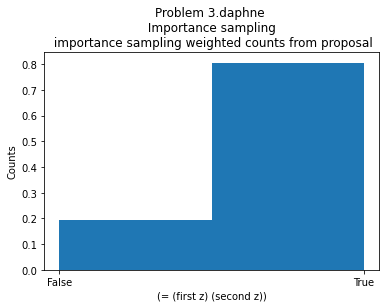

In [39]:
_ = plt.hist(samples.astype(int), weights=probs, bins=2)
plt.xlabel('(= (first z) (second z))')
plt.title('Problem {} \n Importance sampling \n importance sampling weighted counts from proposal'.format(fname))
plt.xticks([0,1],["False","True"])
plt.ylabel('Counts')

In [40]:
method = "Importance sampling"

""" {}: The posterior probability that the first and second datapoint are in the same cluster,\
i.e. the posterior probability that z[1] == z[2]: {:0.3f}\
""".format(method,posterior_mean)

' Importance sampling: The posterior probability that the first and second datapoint are in the same cluster,i.e. the posterior probability that z[1] == z[2]: 0.806'

### MH Gibbs
0.27 s / sample implies ~2.2k samples in 10 min
0.1k in 30.3s implies 1.98k in 10 min

My code is slow, perhaps because of some internal logging and so the burn in needs to be quite large compared with the total run. But the relatively long burn in is justified by the joint increasing.

In [3]:
import graph_based_sampling
import mh_gibbs
from hmc import compute_log_joint_prob

In [4]:
fname = '3.daphne' 
graph = graph_helper(fname)
graph

[{},
 {'V': ['sample5',
   'sample0',
   'observe18',
   'observe12',
   'sample17',
   'sample7',
   'sample9',
   'sample15',
   'sample19',
   'sample6',
   'observe14',
   'observe10',
   'sample13',
   'sample4',
   'sample2',
   'sample1',
   'observe8',
   'sample3',
   'sample11',
   'observe16',
   'observe20'],
  'A': {'sample5': ['observe18',
    'observe12',
    'observe14',
    'observe10',
    'observe8',
    'observe16',
    'observe20'],
   'sample0': ['observe18',
    'observe12',
    'observe14',
    'observe10',
    'observe8',
    'observe16',
    'observe20'],
   'sample17': ['observe18'],
   'sample7': ['observe8'],
   'sample9': ['observe10'],
   'sample15': ['observe16'],
   'sample19': ['observe20'],
   'sample6': ['sample17',
    'sample7',
    'sample9',
    'sample15',
    'sample19',
    'sample13',
    'sample11'],
   'sample13': ['observe14'],
   'sample4': ['observe18',
    'observe12',
    'observe14',
    'observe10',
    'observe8',
    'observe16',
 

In [7]:
%%time
num_steps=19800 # 30s / 10 so 16.5 hrs?
return_list, samples_whole_graph = mh_gibbs.mh_gibbs_wrapper(graph,num_steps)

CPU times: user 1h 38min 30s, sys: 30.1 s, total: 1h 39min
Wall time: 2h 7min 20s


In [8]:
samples = np.array([sample.item() for sample in return_list])

Text(0.5, 1.0, 'MH Gibbs | 3.daphne')

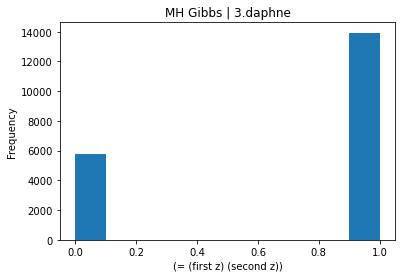

In [50]:
burn_in = 100#int(0.01*num_steps)
pd.Series(samples[burn_in:]).astype(float).plot.hist()
plt.xlabel('(= (first z) (second z))')
plt.title('MH Gibbs | {}'.format(fname))

In [51]:
posterior_mean = samples[burn_in:].mean(0)

In [52]:
method = "MH Gibbs"

""" {}: The posterior probability that the first and second datapoint are in the same cluster,\
i.e. the posterior probability that z[1] == z[2]: {:0.3f}\
""".format(method,posterior_mean)

' MH Gibbs: The posterior probability that the first and second datapoint are in the same cluster,i.e. the posterior probability that z[1] == z[2]: 0.707'

In [56]:
gt = .660
(posterior_mean - gt) / gt

0.0715499751589289

Text(0.5, 1.0, '3.daphne | MH Gibbs \n Sample trace')

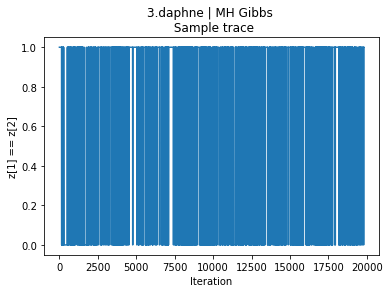

In [13]:
pd.Series(samples).astype(int).plot()
plt.xlabel('Iteration')
plt.ylabel('z[1] == z[2]')
plt.title('{} | MH Gibbs \n Sample trace'.format(fname))

In [14]:
G = graph[1]
Y = G['Y']
Y = {key:evaluate([value])[0] for key,value in Y.items()}
P = G['P']

In [15]:
#%%time
size = len(samples_whole_graph)
jll = np.zeros(size)
for idx in range(size):
    jll[idx] = compute_log_joint_prob(samples_whole_graph[idx],Y,P)

Text(0.5, 1.0, '3.daphne | MH Gibbs \n Joint density')

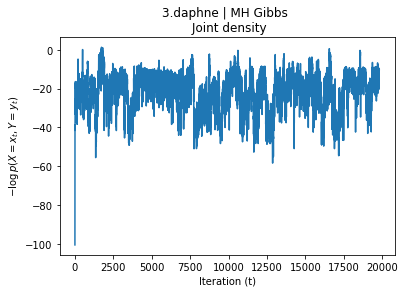

In [16]:
pd.Series(jll).plot()
plt.xlabel('Iteration (t)')
plt.ylabel(r'$-\log p(X=x_t,Y=y_t)$')
plt.title('{} | MH Gibbs \n Joint density'.format(fname))